### Library Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

In [ ]:
from google.colab import files
files.upload()

Saving RetailSales.csv to RetailSales.csv


{'RetailSales.csv': b'Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit\r\n1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0,41.9136\r\n2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.94,3,0,219.582\r\n3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.62,2,0,6.8714\r\n4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean 

### Spark Setup

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop and
3.   Findspark (used to locate the spark in the system)


In [ ]:
# install java 8 and spark 3.1.1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
!ls # check all files we have

RetailSales.csv  sample_data  spark-3.1.1-bin-hadoop3.2  spark-3.1.1-bin-hadoop3.2.tgz


In [ ]:
# set up the home directory for java and spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate() # start a spark session
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

### Exploratory Data Analysis

In [ ]:
# Load data from csv to a dataframe.
# header=True means the first row is a header
df = spark.read.csv('RetailSales.csv', header=True,inferSchema= True)
df.show(5) #show first 5 values

+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|  Customer Name|  Segment|      Country|           City|     State|Postal Code|Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|      42420| South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset 

In [ ]:
df.columns # viewing columns

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales',
 'Quantity',
 'Discount',
 'Profit']

In [ ]:
df.dtypes

[('Row ID', 'int'),
 ('Order ID', 'string'),
 ('Order Date', 'string'),
 ('Ship Date', 'string'),
 ('Ship Mode', 'string'),
 ('Customer ID', 'string'),
 ('Customer Name', 'string'),
 ('Segment', 'string'),
 ('Country', 'string'),
 ('City', 'string'),
 ('State', 'string'),
 ('Postal Code', 'int'),
 ('Region', 'string'),
 ('Product ID', 'string'),
 ('Category', 'string'),
 ('Sub-Category', 'string'),
 ('Product Name', 'string'),
 ('Sales', 'string'),
 ('Quantity', 'string'),
 ('Discount', 'string'),
 ('Profit', 'double')]

In [ ]:
df.printSchema()

root
 |-- Row ID: string (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- Profit: string (nullable = true)



### Schema Modification
- The schema of our csv registers Sales, Proft, Discount to a string type, which is inconvenient for data analysis, we'll modify the Schema using **Struct Type** in Spark

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
schema = StructType([
    StructField("Row ID", StringType(), True),
    StructField("Order ID", StringType(), True),
    StructField("Order Date", StringType(), True),
    StructField("Ship Date", StringType(), True),
    StructField("Ship Mode", StringType(), True),
    StructField("Customer ID", StringType(), True),
    StructField("Customer Name", StringType(), True),
    StructField("Segment", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("City", StringType(), True),
    StructField("State", StringType(), True),
    StructField("Postal Code", StringType(), True),
    StructField("Region", StringType(), True),
    StructField("Product ID", StringType(), True),
    StructField("Category", StringType(), True),
    StructField("Sub-Category", StringType(), True),
    StructField("Product Name", StringType(), True),
    StructField("Sales", DoubleType(), True),
    StructField("Quantity", IntegerType(), True),
    StructField("Discount", DoubleType(), True),
    StructField("Profit", DoubleType(), True)
])

In [ ]:
df = spark.read.csv('RetailSales.csv', header=True,schema= schema)
df.show(5) #show first 5 values

+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|  Customer Name|  Segment|      Country|           City|     State|Postal Code|Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|      42420| South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset 

### Drop Unnecessary Data Tables

- We'll drop 'Country' out of our database as the only country here is United States so keep this column would yield no beneficial insights
- We also dont need any Postal Code and Row ID to get useful insights, so we'lll drop it.


In [ ]:
#Remove columns in PySpark
df = df.drop('Row ID','Country','Postal Code')
df.show(5,truncate=False)

+--------------+----------+----------+--------------+-----------+---------------+---------+---------------+----------+------+---------------+---------------+------------+-----------------------------------------------------------+--------+--------+--------+--------+
|Order ID      |Order Date|Ship Date |Ship Mode     |Customer ID|Customer Name  |Segment  |City           |State     |Region|Product ID     |Category       |Sub-Category|Product Name                                               |Sales   |Quantity|Discount|Profit  |
+--------------+----------+----------+--------------+-----------+---------------+---------+---------------+----------+------+---------------+---------------+------------+-----------------------------------------------------------+--------+--------+--------+--------+
|CA-2016-152156|11/8/2016 |11/11/2016|Second Class  |CG-12520   |Claire Gute    |Consumer |Henderson      |Kentucky  |South |FUR-BO-10001798|Furniture      |Bookcases   |Bush Somerset Collection Book

In [ ]:
### Dropping missing values, and duplicates

df.dropDuplicates().show()

+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+-------------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+----------+
|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|         City|        State| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|    Profit|
+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+-------------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+----------+
|CA-2014-143336| 8/27/2014|  9/1/2014|  Second Class|   ZD-21925|Zuschuss Donatelli|   Consumer|San Francisco|   California|   West|TEC-PH-10001949|     Technology|      Phones|Cisco SPA 501G IP...|  213.48|       3|     0.2|    16.011|
|CA-2016-111682| 6/17/2016| 6/18/2016|   First Class

### Data Types Handling
- To enhance the consistency, and accuracy of our data. We need to convert all data to the suitable data type.
- In this case, we will convert 'Order Date' and 'Ship Date' to a date time data

In [ ]:
df.dtypes

[('Order ID', 'string'),
 ('Order Date', 'string'),
 ('Ship Date', 'string'),
 ('Ship Mode', 'string'),
 ('Customer ID', 'string'),
 ('Customer Name', 'string'),
 ('Segment', 'string'),
 ('City', 'string'),
 ('State', 'string'),
 ('Region', 'string'),
 ('Product ID', 'string'),
 ('Category', 'string'),
 ('Sub-Category', 'string'),
 ('Product Name', 'string'),
 ('Sales', 'double'),
 ('Quantity', 'int'),
 ('Discount', 'double'),
 ('Profit', 'double')]

In [ ]:
from pyspark.sql.functions import to_date
df = df.withColumn("Order Date", to_date(df["Order Date"], "MM/dd/yyyy"))
df = df.withColumn("Ship Date", to_date(df["Ship Date"], "MM/dd/yyyy"))

In [ ]:
# Set the Spark configuration to use the legacy time parser
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Continue with your operations
df.show()


+--------------+----------+----------+--------------+-----------+------------------+-----------+---------------+--------------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|           City|         State| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+--------------+----------+----------+--------------+-----------+------------------+-----------+---------------+--------------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|CA-2016-152156|2016-11-08|2016-11-11|  Second Class|   CG-12520|       Claire Gute|   Consumer|      Henderson|      Kentucky|  South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset Col...|  261.96|       2|     0.0| 41.9136|
|CA-2016-152156|2016-11-08|2016-11-11|  Second C

In [ ]:
# Extract year and month from 'Order Date' and create new columns
from pyspark.sql.functions import year, month, to_date
df = df.withColumn("Year", year(df["Order Date"])) \
       .withColumn("Month", month(df["Order Date"]))

# Show the updated DataFrame
df.show()

+--------------+----------+----------+--------------+-----------+------------------+-----------+---------------+--------------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+----+-----+
|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|           City|         State| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|Year|Month|
+--------------+----------+----------+--------------+-----------+------------------+-----------+---------------+--------------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+----+-----+
|CA-2016-152156|2016-11-08|2016-11-11|  Second Class|   CG-12520|       Claire Gute|   Consumer|      Henderson|      Kentucky|  South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset Col...|  261.96|       2|     0.0| 41.9136|2016|   11|
|CA-

### Data Exploratory Analysis


In [ ]:
# summary stats
df.describe()

summary,Order ID,Ship Mode,Customer ID,Customer Name,Segment,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9694,9694,9983,9994,9994,9994
mean,null,null,null,null,null,null,null,null,null,null,null,null,234.41818199917006,3.7909015886115123,0.3155949113492862,28.587912967780834,2015.722233340004,7.809685811486892
stddev,null,null,null,null,null,null,null,null,null,null,null,null,631.7890112674363,2.2273345138146503,3.314008629792499,234.3891156047269,1.1235549110442766,3.284654397269433
min,CA-2014-100006,First Class,AA-10315,Aaron Bergman,Consumer,Aberdeen,Alabama,Central,FUR-BO-10000112,Furniture,Accessories,"""""""While you Were...",0.444,1,0.0,-6599.978,2014,1
max,US-2017-169551,Standard Class,ZD-21925,Zuschuss Donatelli,Home Office,Yuma,Wyoming,West,TEC-PH-10004977,Technology,Tables,netTALK DUO VoIP ...,22638.48,14,295.056,8399.976,2017,12


### Inference From The Above Summary Statistics
- The mean of sales is 234.42 while the mean of profit is only 28.59. These values suggest that on average, each order generates about 234.42 in revenue and 28.59. This indicates that we have a very low profit margin, and we may have lose our money in other means like marketing, discount campaigns, and others.
- The lowest point of profit is 	-6599.978, this indicates that there are some orders that only bring monetary loss to the company. Consider the scenario that we are applying discount vouchers, it indicates that, customers may apply multiple vouchers to the point that we didnt earn any profit from a specific order.
- We have to consider the correlation of these vouchers with our sales, to see if applying the current discount policy, to identify the benefits of revenue that these discount vouchers bring. Are the sales these vouchers bring able to compensate for the loss we're enduring. If not, we have to reconsider our pricing stategy (increase the sold out price for product), or to reduce the number of discount vouchers released in our platform, or to release largest the percentage discount per order.
- We will also visualize the sales and profit over year and month, to see the key sale trend. If the sale continues to drop over time or in specific pattern, we need to identify the key reason for that slump in sales/ profit
- We will also run a RFM analysis ( Recency, Frequency, Monetary), to classify customers into cohorts, and focus the efforts of loyalt programs ( discount vouchers) or personalized marketing into the best customers.

### Profit Margin

In [ ]:
from pyspark.sql.functions import mean
from pyspark.sql.functions import expr
df = df.withColumn("Profit Margin", (expr("Profit / Sales * 100")))

# Calculate mean of Profit Margin
mean_profit_margin = df.select(mean("Profit Margin")).collect()[0][0]

print(f"Mean Profit Margin: {mean_profit_margin:.2f}%")

Mean Profit Margin: 12.07%


In [ ]:
df.describe()

summary,Order ID,Ship Mode,Customer ID,Customer Name,Segment,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month,Profit Margin
count,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9994,9694,9694,9983,9994,9994,9994,9694
mean,null,null,null,null,null,null,null,null,null,null,null,null,234.41818199917006,3.7909015886115123,0.3155949113492862,28.587912967780834,2015.722233340004,7.809685811486892,12.074022559990235
stddev,null,null,null,null,null,null,null,null,null,null,null,null,631.7890112674363,2.2273345138146503,3.314008629792499,234.3891156047269,1.1235549110442766,3.284654397269433,46.421786961634275
min,CA-2014-100006,First Class,AA-10315,Aaron Bergman,Consumer,Aberdeen,Alabama,Central,FUR-BO-10000112,Furniture,Accessories,"""""""While you Were...",0.444,1,0.0,-6599.978,2014,1,-275.0
max,US-2017-169551,Standard Class,ZD-21925,Zuschuss Donatelli,Home Office,Yuma,Wyoming,West,TEC-PH-10004977,Technology,Tables,netTALK DUO VoIP ...,22638.48,14,295.056,8399.976,2017,12,50.0


### Insights:
- The minimum profit margin of -270% is unusually low and suggests that there are some instances where costs significantly exceed sales. This could point to issues like extreme discounts, high costs relative to sales, or potentially loss-making products or transactions.
- The wide range between the maximum and minimum profit margins (from 50% to -270%) indicates significant variability in profitability. This suggests that while some transactions or products are highly profitable, others might be deeply unprofitable
- We will select product with lowest profit margin over time, to examine which factors contribute to this.

### Correlation Heatmap


In [ ]:
df.printSchema()

root
 |-- Order ID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Profit Margin: double (nullable = true)



In [ ]:
# Sort by 'Profit Margin' in ascending order and select the top 10
from pyspark.sql.functions import col
df.select("Product Name", "Profit Margin").show(10)

+--------------------+------------------+
|        Product Name|     Profit Margin|
+--------------------+------------------+
|Bush Somerset Col...|16.000000000000004|
|Hon Deluxe Fabric...|              30.0|
|Self-Adhesive Add...|              47.0|
|Bretford CR4500 S...|             -40.0|
|Eldon Fold 'N Rol...|             11.25|
|Eldon Expressions...|28.999999999999996|
|          Newell 322|              27.0|
|Mitel 5320 IP Pho...|              10.0|
|DXL Angle-View Bi...|31.249999999999993|
|Belkin F5C206VTEL...|              30.0|
+--------------------+------------------+
only showing top 10 rows



In [ ]:
# Filter out rows with null Profit Margin
df_filtered = df.filter(col("Profit Margin").isNotNull())

# Sort by 'Profit Margin' in ascending order and select the top 10
lowest_profit_margin_df = df_filtered.orderBy(col("Profit Margin").asc()).limit(10)

# Show the results
lowest_profit_margin_df.show(10)

+--------------+----------+----------+--------------+-----------+----------------+---------+----------+--------+-------+---------------+---------------+------------+--------------------+-------+--------+--------+---------+----+-----+-------------+
|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|   Customer Name|  Segment|      City|   State| Region|     Product ID|       Category|Sub-Category|        Product Name|  Sales|Quantity|Discount|   Profit|Year|Month|Profit Margin|
+--------------+----------+----------+--------------+-----------+----------------+---------+----------+--------+-------+---------------+---------------+------------+--------------------+-------+--------+--------+---------+----+-----+-------------+
|US-2017-155299|2017-06-08|2017-06-12|Standard Class|   Dl-13600|    Dorris liebe|Corporate|  Pasadena|   Texas|Central|OFF-AP-10002203|Office Supplies|  Appliances|Eureka Disposable...|  1.624|       2|     0.8|   -4.466|2017|    6|       -275.0|
|US-2017

### Insight:
- The total of orders, and distinct orders are far different from each other. This could be explained by several reasons.

- Multiple Items per Order: Each Order ID might represent multiple items purchased in a single order. Each item might be listed as a separate row in your dataset, resulting in multiple rows with the same Order ID.

- Split Shipments or Deliveries: Orders might be split into multiple shipments or deliveries, where each shipment or delivery is recorded as a separate row with the same Order ID

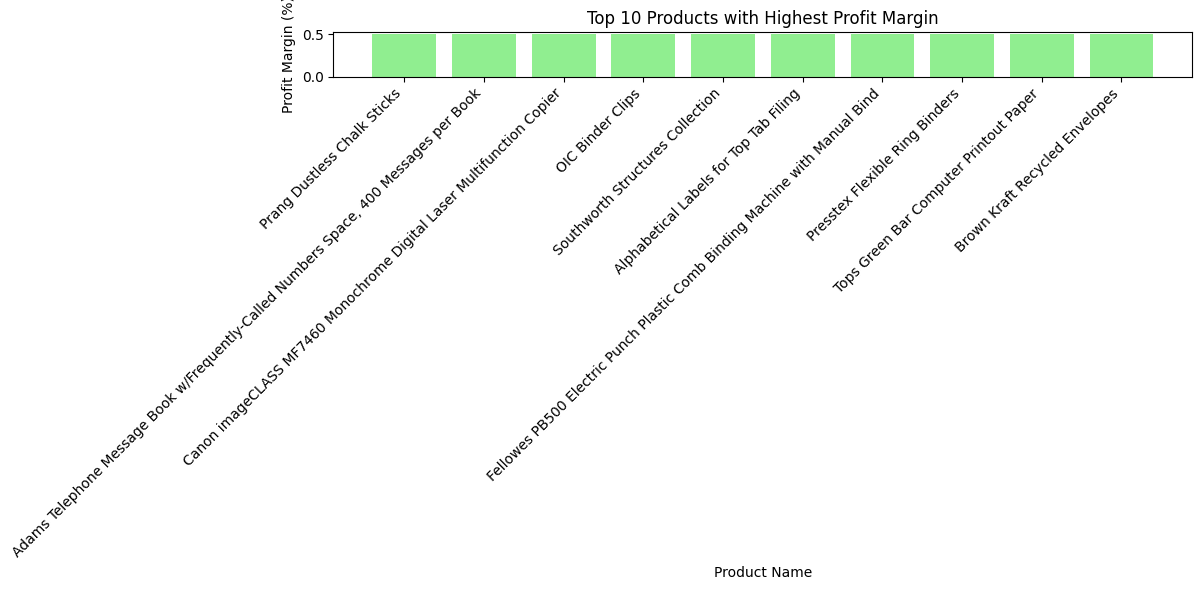

In [ ]:
# Plotting top 10 products with highest profit margin
plt.figure(figsize=(12, 6))
plt.bar(top_10_profit_margin['Product Name'], top_10_profit_margin['Profit Margin (%)'], color='lightgreen')
plt.xlabel('Product Name')
plt.ylabel('Profit Margin (%)')
plt.title('Top 10 Products with Highest Profit Margin')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Revenue Distribution By Product Category Over Time

In [ ]:
# extract month & year from order date
df['YearMonth'] = df['Order Date'].dt.to_period('M')

In [ ]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Profit Margin (%),YearMonth
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,0.1600,2016-11
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,0.3000,2016-11
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,0.4700,2016-06
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,-0.4000,2015-10
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,0.1125,2015-10


In [ ]:
df.dtypes

Order ID                     object
Order Date           datetime64[ns]
Ship Date            datetime64[ns]
Ship Mode                    object
Customer ID                  object
Customer Name                object
Segment                      object
City                         object
State                        object
Region                       object
Product ID                   object
Category                     object
Sub-Category                 object
Product Name                 object
Sales                       float64
Quantity                      int64
Discount                    float64
Profit                      float64
Profit Margin (%)           float64
YearMonth                 period[M]
dtype: object

In [ ]:
df['Year'] = df['Order Date'].dt.year

### Profit Distribution By Product Category Over Time

In [ ]:
# Group by Year and Month-Year, and calculate the mean Profit
profit_by_month_year = df.groupby(['Year', 'YearMonth','Category'])['Profit'].mean().reset_index()

In [ ]:
# Get the list of unique years
years = profit_by_month_year['Year'].unique()

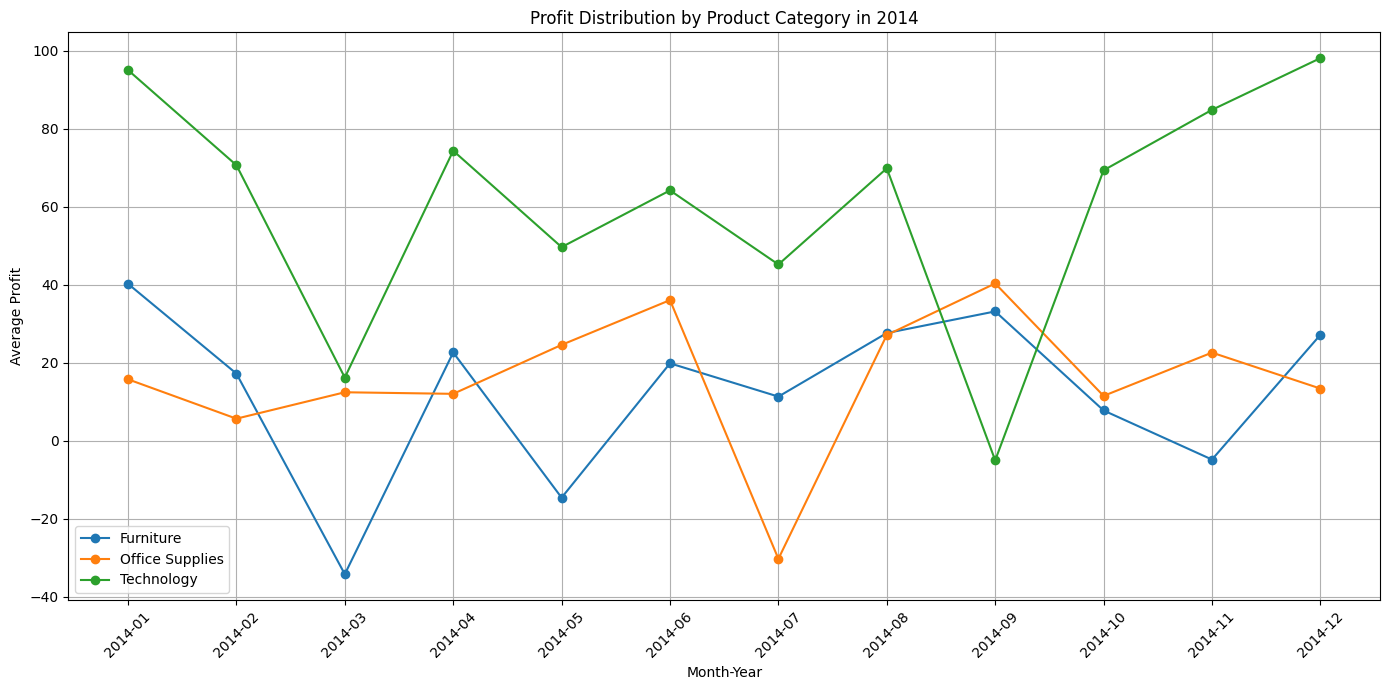

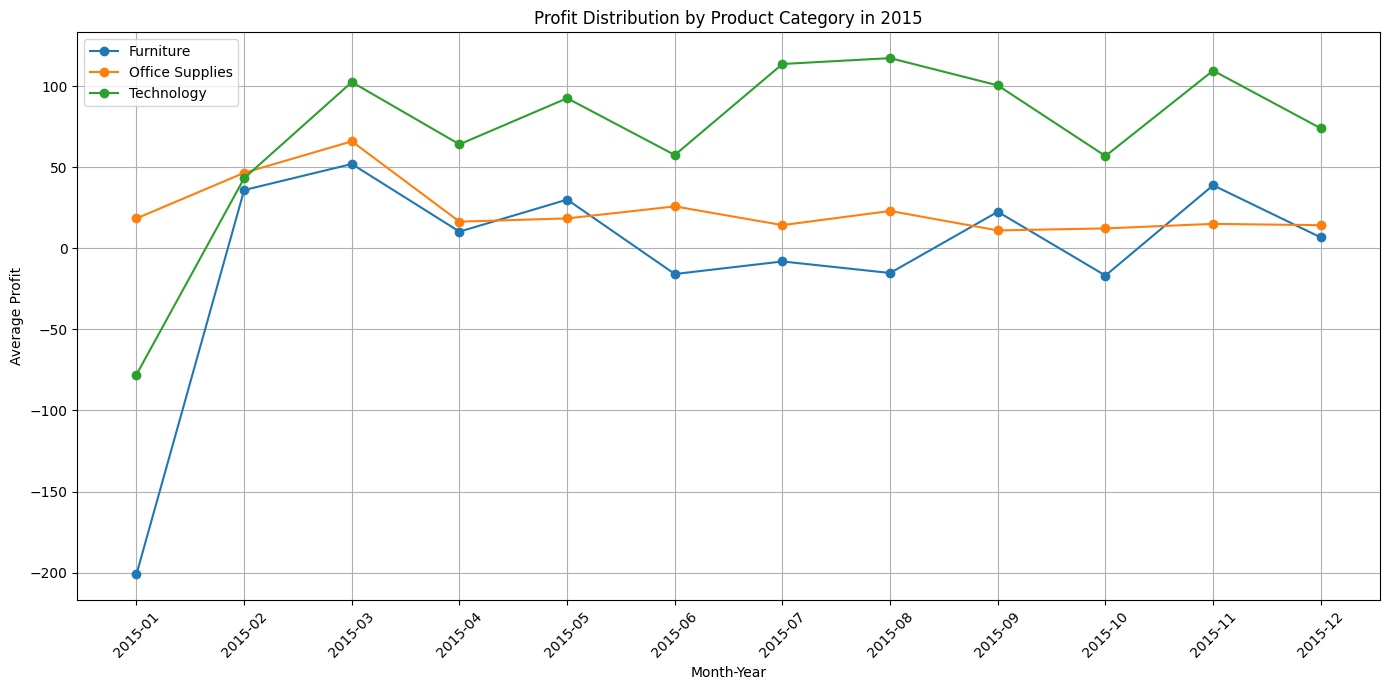

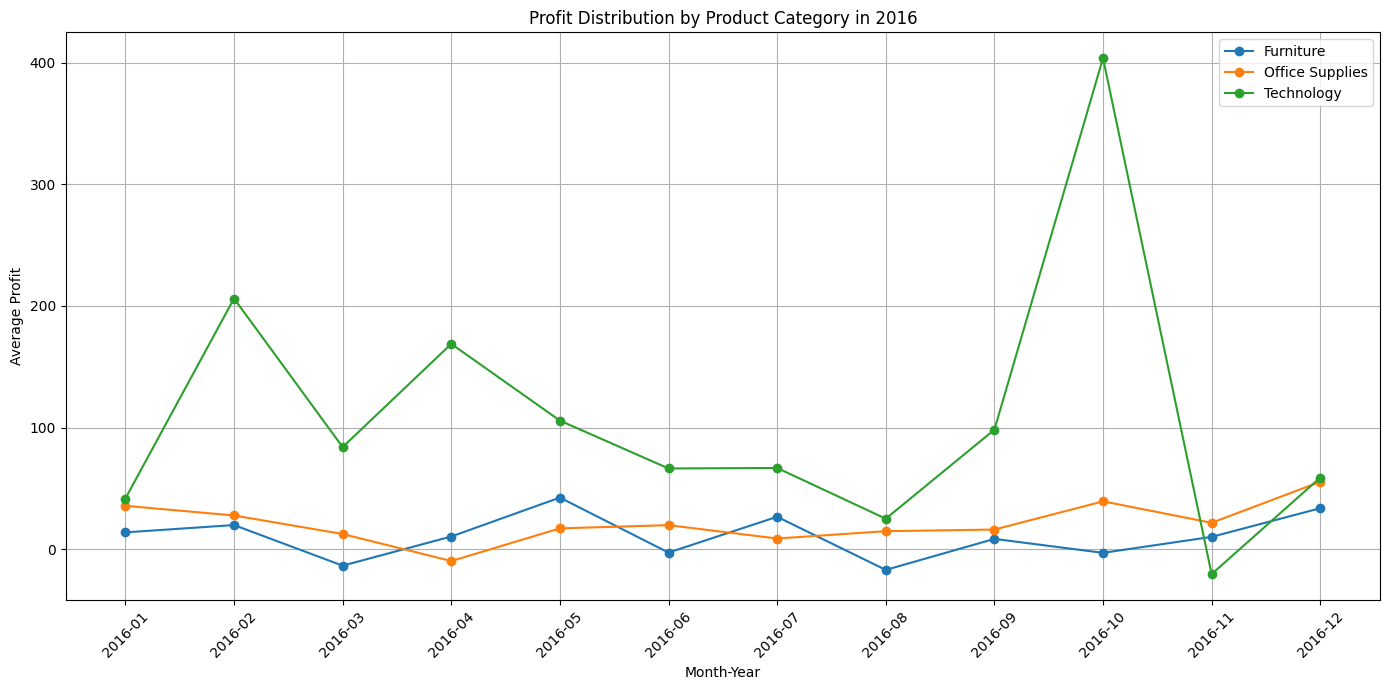

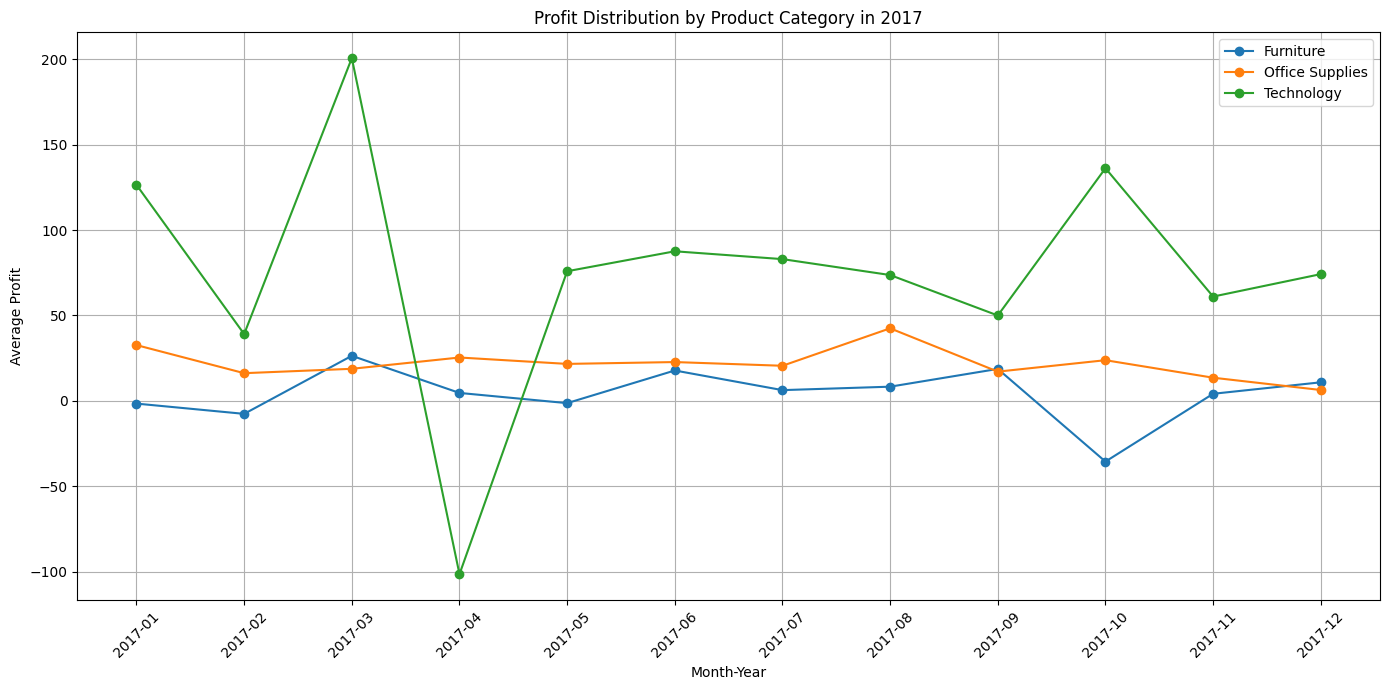

In [ ]:
for year in years:
    plt.figure(figsize=(14, 7))
    yearly_data = profit_by_month_year[profit_by_month_year['Year'] == year]

    # Plot each category separately
    for category in df['Category'].unique():
        category_data = yearly_data[yearly_data['Category'] == category]
        plt.plot(category_data['YearMonth'].astype(str), category_data['Profit'], marker='o', linestyle='-', label=category)

    plt.title(f'Profit Distribution by Product Category in {year}')
    plt.xlabel('Month-Year')
    plt.ylabel('Average Profit')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Revenue Distribution By Category

In [ ]:
# Group by Year and Month-Year, and calculate the mean Profit
sales_by_month_year = df.groupby(['Year', 'YearMonth','Category'])['Sales'].mean().reset_index()

In [ ]:
# Get the list of unique years
years = sales_by_month_year['Year'].unique()

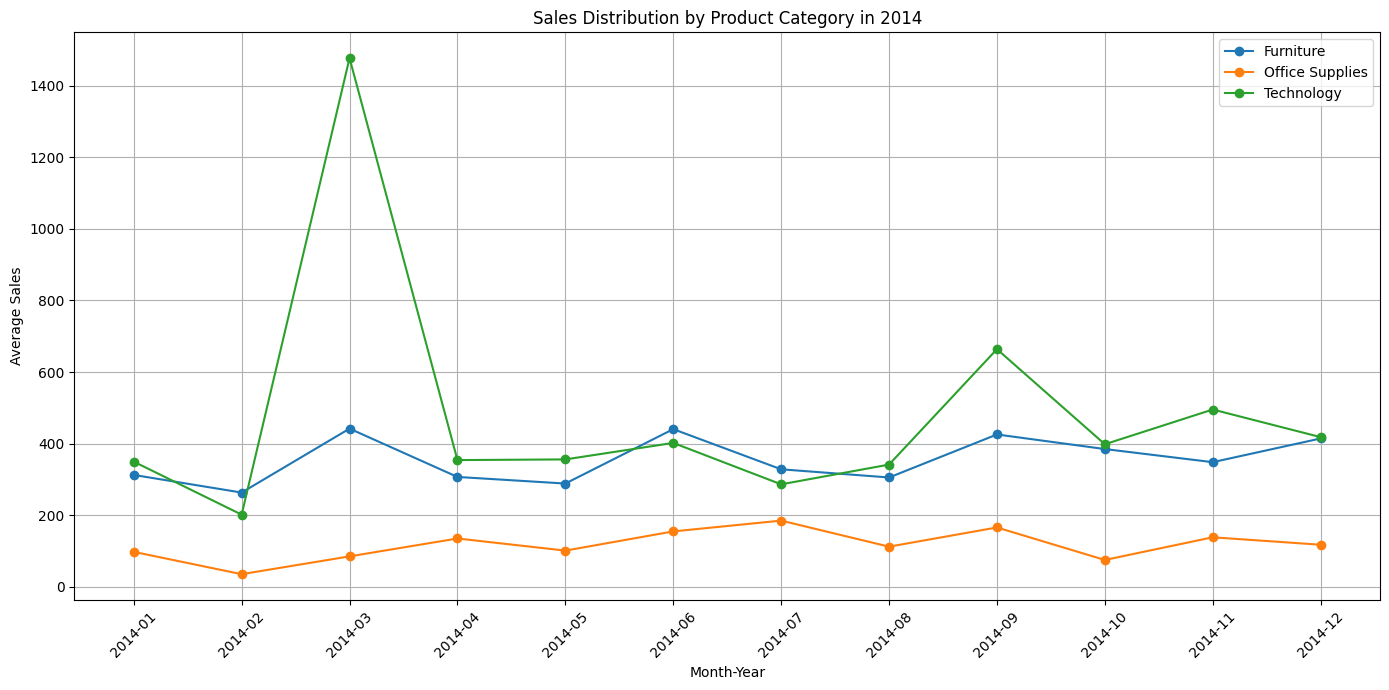

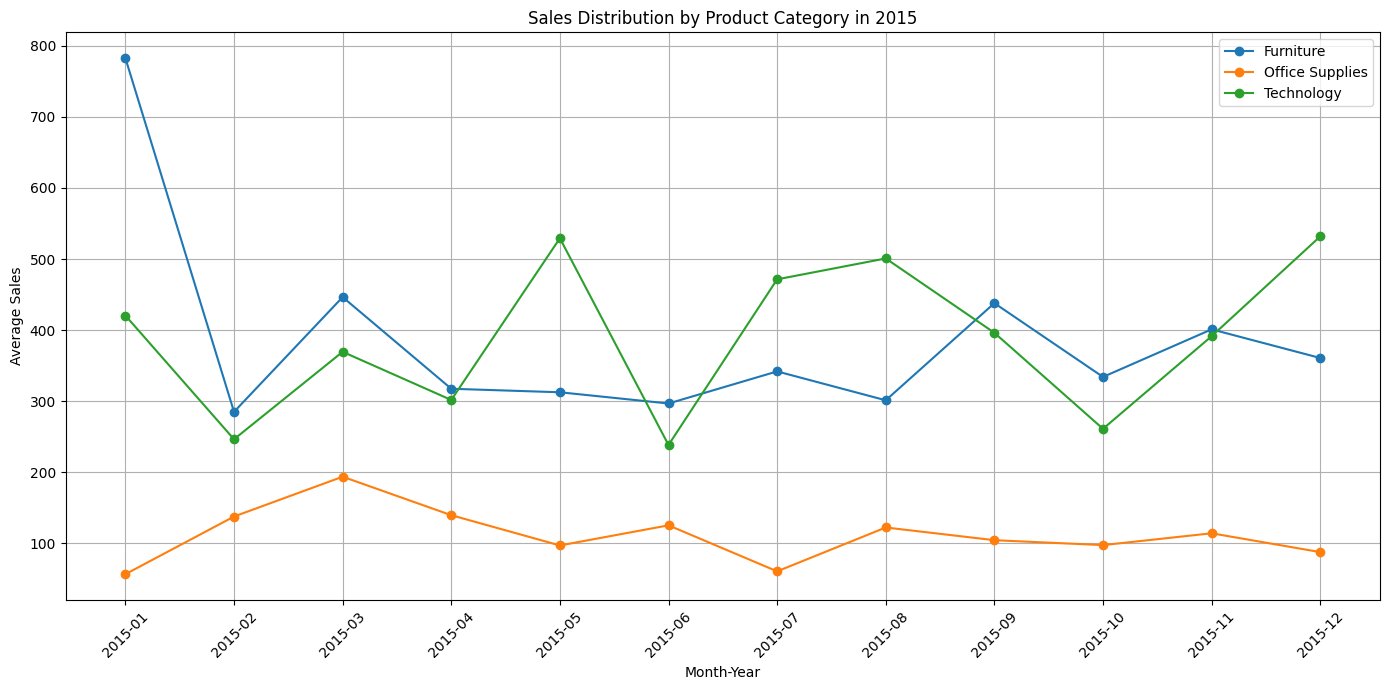

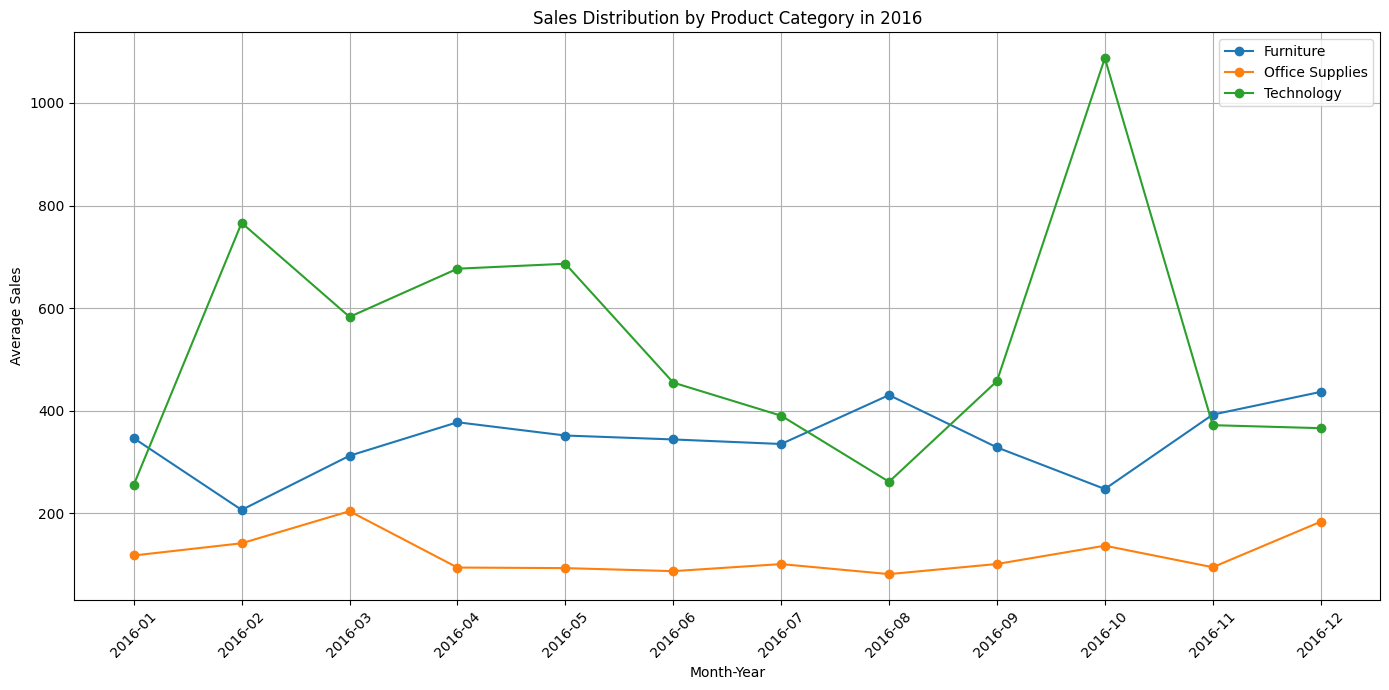

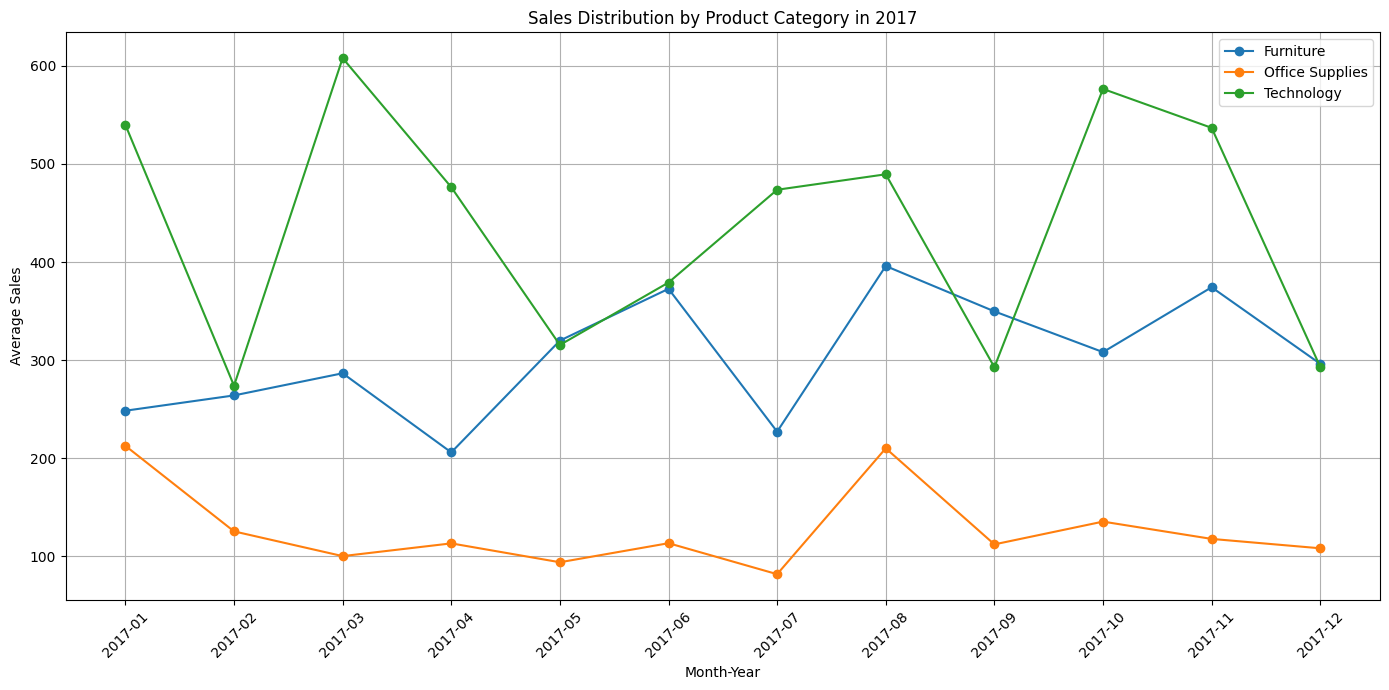

In [ ]:
for year in years:
    plt.figure(figsize=(14, 7))
    yearly_data = sales_by_month_year[sales_by_month_year['Year'] == year]

    # Plot each category separately
    for category in df['Category'].unique():
        category_data = yearly_data[yearly_data['Category'] == category]
        plt.plot(category_data['YearMonth'].astype(str), category_data['Sales'], marker='o', linestyle='-', label=category)

    plt.title(f'Sales Distribution by Product Category in {year}')
    plt.xlabel('Month-Year')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Revenue Contribution By Category

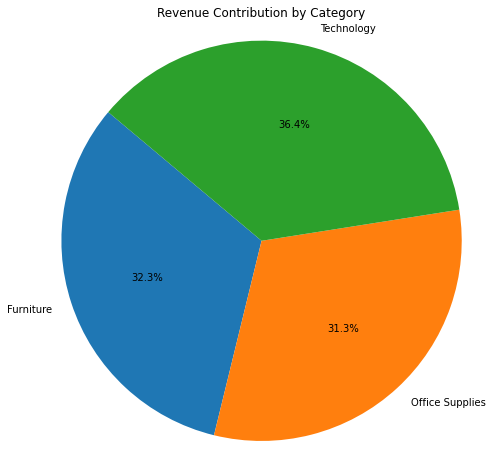

In [ ]:
# Calculate total sales for each category
category_sales = df.groupby('Category')['Sales'].sum()

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140)
plt.title('Revenue Contribution by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Revenue Contribution By Sub Category

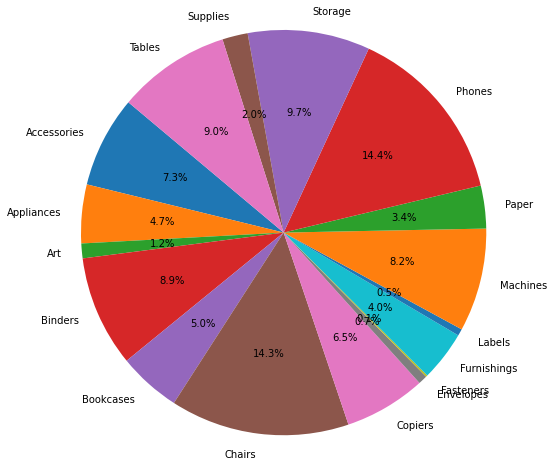

In [ ]:
# Calculate total sales for each category
category_sales = df.groupby('Sub-Category')['Sales'].sum()

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Profit Contribution By Category

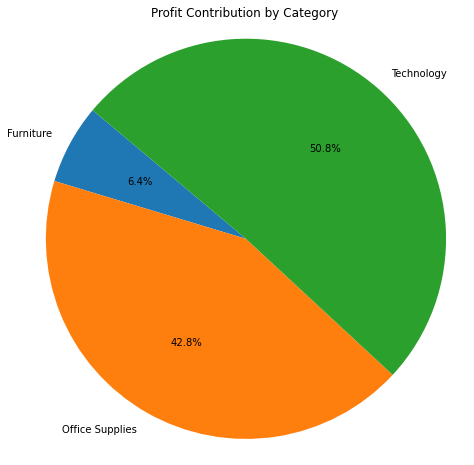

In [ ]:
# Calculate total sales for each category
category_sales = df.groupby('Category')['Profit'].sum()

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140)
plt.title('Profit Contribution by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Profit Contribution By Sub Category

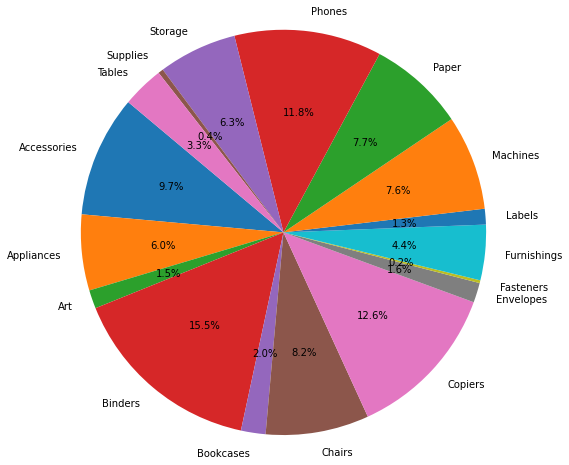

In [ ]:
# Clean data: remove negative values or replace with appropriate handling
df['Profit'] = df['Profit'].clip(lower=0)  # Clip negative values to zero

# Calculate total profit for each sub-category
category_sales = df.groupby('Sub-Category')['Profit'].sum()

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_sales, labels=category_sales.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Average Delivery Time
-  Shorter delivery times often lead to higher customer satisfaction. Satisfied customers are more likely to return for future purchases
- In this case, we'll analyze the average delivery time for each ship mode, and then try to optimize the delivery time by choosing the ship mode with shortest delivery time

In [ ]:
# Calculate delivery time (in days)
df['Delivery Time'] = (df['Ship Date'] - df['Order Date']).dt.days

# Calculate average delivery time
average_delivery_time = df['Delivery Time'].mean()

print(f"Average Delivery Time: {average_delivery_time} days")

Average Delivery Time: 3.9581707195036526 days


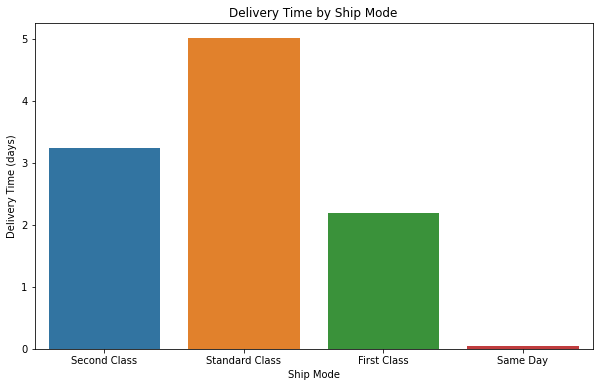

In [ ]:
# Plotting delivery time by ship mode
plt.figure(figsize=(10, 6))
sns.barplot(x='Ship Mode', y='Delivery Time', data=df, ci=None)
plt.title('Delivery Time by Ship Mode')
plt.xlabel('Ship Mode')
plt.ylabel('Delivery Time (days)')
plt.show()

### RFM ANALYSIS

- We'll look for three main aspects: Recency- Frequency- Monetary.
- Recency: How long from the last purchases?
- Frequency: How many orders this customer has placed?
- Monetary: How many money they have spent on our products?
- RFM will helps us to segment our customers into cohorts, which help us to grab a better understanding of our customers, and hence, we'll come up a better customer service strategy.
- In this case, we will identify high-value customers (who purchase frequently and spend more), potential loyal customers, and at-risk customers (who haven't made a purchase in a while).

In [ ]:
# caculate recency for all customers
snapshot_date = pd.to_datetime('2024-07-10')
df['Recency']=(snapshot_date - df.groupby('Customer ID')['Order Date'].transform('max')).dt.days

In [ ]:
# Display the results
print(df[['Customer ID', 'Order Date', 'Recency']].head())

  Customer ID Order Date  Recency
0    CG-12520 2016-11-08     2722
1    CG-12520 2016-11-08     2722
2    DV-13045 2016-06-12     2403
3    SO-20335 2015-10-11     2413
4    SO-20335 2015-10-11     2413


In [ ]:
# caculate frequency for all customers
df['Frequency']= df.groupby('Customer ID')['Order ID'].transform('count')

In [ ]:
# Display the results
print(df[['Customer ID', 'Frequency']].head())

  Customer ID  Frequency
0    CG-12520          5
1    CG-12520          5
2    DV-13045          9
3    SO-20335         15
4    SO-20335         15


In [ ]:
# caculate monetary for all customers
df['Monetary']= df.groupby('Customer ID')['Sales'].transform('sum')

In [ ]:
# Display the results
print(df[['Customer ID', 'Monetary']].head())

  Customer ID   Monetary
0    CG-12520  1148.7800
1    CG-12520  1148.7800
2    DV-13045  1119.4830
3    SO-20335  2602.5755
4    SO-20335  2602.5755


In [ ]:
df.describe()

,Sales,Quantity,Discount,Profit,Profit Margin (%),Year,Delivery Time,Recency,Frequency,Monetary
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,229.852846,3.789753,0.156188,44.283829,0.120330,2015.722406,3.958171,2504.277895,15.687882,3592.907579
std,623.276074,2.225149,0.206457,193.131299,0.466775,1.123479,1.747654,154.848521,6.652109,2837.729644
min,0.444000,1.000000,0.000000,0.000000,-2.750000,2014.000000,0.000000,2384.000000,1.000000,4.833000
25%,17.280000,2.000000,0.000000,1.731000,0.075000,2015.000000,3.000000,2412.000000,11.000000,1669.135000
50%,54.480000,3.000000,0.200000,8.671000,0.270000,2016.000000,4.000000,2444.000000,15.000000,2872.630000
75%,209.940000,5.000000,0.200000,29.364000,0.362500,2017.000000,5.000000,2530.000000,20.000000,4704.304000
max,22638.480000,14.000000,0.800000,8399.976000,0.500000,2017.000000,7.000000,3549.000000,37.000000,25043.050000


In [ ]:
# divide each value into 4 equal bins
df['R_score'] = pd.qcut(df['Recency'], q=4, labels=False, duplicates='drop') + 1  # Recency score (1 to 4)
df['F_score'] = pd.qcut(df['Frequency'], q=4, labels=False, duplicates='drop') + 1  # Frequency score (1 to 4)
df['M_score'] = pd.qcut(df['Monetary'], q=4, labels=False, duplicates='drop') + 1  # Monetary score (1 to 4)

In [ ]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'City', 'State', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Profit Margin (%)', 'YearMonth', 'Year',
       'Delivery Time', 'Recency', 'Frequency', 'Monetary', 'R_score',
       'F_score', 'M_score'],
      dtype='object')

In [ ]:
df['RFM_Score'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)

# Display the segmented customers
print(df[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']].sort_values(by='RFM_Score'))

     Customer ID  Recency  Frequency   Monetary RFM_Score
2175    PB-18805     2409         10    740.356       111
756     DC-13285     2407          7   1174.618       111
5837    DO-13645     2410         11   1267.316       111
8177    CM-12115     2392          7   1661.610       111
8175    HE-14800     2396         11    883.532       111
...          ...      ...        ...        ...       ...
1636    NW-18400     2556         22   7234.014       444
1635    NW-18400     2556         22   7234.014       444
786     CL-12565     2668         28  10880.546       444
5300    AH-10690     2794         23   7888.294       444
2617    MS-17365     2657         24   7443.690       444

[9993 rows x 5 columns]


In [ ]:
df['RFM_Score'].describe()

count     9993
unique      62
top        411
freq       652
Name: RFM_Score, dtype: object

### Customer Segmentation:


In [ ]:
def classify_rfm(rfm_score):
    r, f, m = map(int, rfm_score)

    if r == 4 and (f == 3 or f == 4) and (m == 3 or m == 4):
        return 'Best Customers'
    elif f == 3 or f == 4:
        return 'Loyal Customers'
    elif r == 3 or r == 4 and (m == 3 or m == 4):
        return 'Potential Loyalists'
    elif r == 2 or r == 3 and f == 2 and m == 2:
        return 'Needs Attention'
    else:
        return 'At Risk'

In [ ]:
# Apply the classification function
df['RFM_Cohort'] = df['RFM_Score'].apply(classify_rfm)

In [ ]:
# Display the classified customers
print(df[['Customer Name', 'RFM_Score', 'RFM_Cohort']])

         Customer Name RFM_Score       RFM_Cohort
0          Claire Gute       411          At Risk
1          Claire Gute       411          At Risk
2      Darrin Van Huff       111          At Risk
3       Sean O'Donnell       222  Needs Attention
4       Sean O'Donnell       222  Needs Attention
...                ...       ...              ...
9989  Tom Boeckenhauer       434   Best Customers
9990       Dave Brooks       123          At Risk
9991       Dave Brooks       123          At Risk
9992       Dave Brooks       123          At Risk
9993      Chris Cortes       143  Loyal Customers

[9993 rows x 3 columns]


In [ ]:
# Save the dataframe to a CSV file in the specified directory
df.to_csv(r"C:\Users\tanvu\OneDrive\Desktop\DSDV\Retail-Sales-Analysis-Visualization-1\customer_rfm_analysis1.csv", index=False)


### K-means Clustering
- Next, we'll build a K-means Clustering model to classify customers into cohorts. First, we'll build a pipeline to transform our data into feature matrix.

In [ ]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Region,...,Year,Delivery Time,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,RFM_Cohort
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,...,2016,3,2722,5,1148.7800,4,1,1,411,At Risk
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,...,2016,3,2722,5,1148.7800,4,1,1,411,At Risk
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,West,...,2016,4,2403,9,1119.4830,1,1,1,111,At Risk
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,South,...,2015,7,2413,15,2602.5755,2,2,2,222,Needs Attention
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,South,...,2015,7,2413,15,2602.5755,2,2,2,222,Needs Attention


In [ ]:
df.corr()

,Sales,Quantity,Discount,Profit,Profit Margin (%),Year,Delivery Time,Recency,Frequency,Monetary,R_score,F_score,M_score
Sales,1.000000,0.200808,-0.028197,0.755945,0.003447,-0.009667,-0.007354,0.005845,-0.003135,0.219091,0.007949,-0.005898,0.168208
Quantity,0.200808,1.000000,0.008680,0.124894,-0.005308,-0.005934,0.018301,0.012946,-0.001702,0.035535,-0.003610,-0.002662,0.047374
Discount,-0.028197,0.008680,1.000000,-0.113489,-0.864454,-0.002556,0.000407,0.000448,-0.004054,-0.033083,-0.007395,0.007542,-0.030806
Profit,0.755945,0.124894,-0.113489,1.000000,0.102188,0.006041,0.000472,0.007638,-0.001636,0.167268,0.009322,-0.003894,0.120679
Profit Margin (%),0.003447,-0.005308,-0.864454,0.102188,1.000000,-0.000015,-0.011815,-0.000170,0.002427,0.012890,0.009027,-0.009368,0.010225
Year,-0.009667,-0.005934,-0.002556,0.006041,-0.000015,1.000000,-0.022735,-0.214052,-0.010403,-0.027013,-0.156978,-0.012865,-0.028132
Delivery Time,-0.007354,0.018301,0.000407,0.000472,-0.011815,-0.022735,1.000000,0.013555,-0.000607,0.030230,0.005610,-0.002684,0.025327
Recency,0.005845,0.012946,0.000448,0.007638,-0.000170,-0.214052,0.013555,1.000000,-0.217683,-0.072018,0.718605,-0.197739,-0.140163
Frequency,-0.003135,-0.001702,-0.004054,-0.001636,0.002427,-0.010403,-0.000607,-0.217683,1.000000,0.502289,-0.174385,0.925685,0.569633
Monetary,0.219091,0.035535,-0.033083,0.167268,0.012890,-0.027013,0.030230,-0.072018,0.502289,1.000000,-0.041559,0.459301,0.813167


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [ ]:
X=df[['R_score','F_score','M_score','RFM_Score']]
X.head()

,R_score,F_score,M_score,RFM_Score
0,4,1,1,411
1,4,1,1,411
2,1,1,1,111
3,2,2,2,222
4,2,2,2,222


In [ ]:
X.shape

(9993, 4)

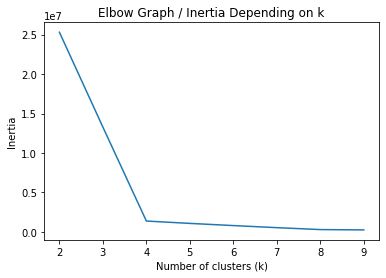

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
km_inertias, km_scores = [], []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X, km.labels_))

# Plotting the elbow graph
sns.lineplot(x=range(2, 10), y=km_inertias)
plt.title('Elbow Graph / Inertia Depending on k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


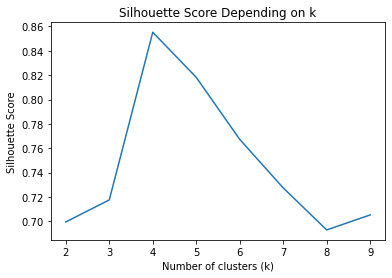

In [ ]:
# Plotting the silhouette scores
sns.lineplot(x=range(2, 10), y=km_scores)
plt.title('Silhouette Score Depending on k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
km = KMeans(n_clusters=4).fit(X)
labels = km.labels_
accuracy= silhouette_score(X, labels)
print("Accuracy:",accuracy)

Accuracy: 0.855266391733493


In [ ]:
df['Cluster'] = km.fit_predict(X)

In [ ]:
# Calculate the statistical summary for each cluster
cluster_summary = df.groupby('Cluster').describe().transpose()

# Print the clusters and their statistical summary
print("Cluster Labels:")
print(df[['Recency', 'Frequency', 'Monetary', 'Cluster']])
print("\nStatistical Summary by Cluster:")
print(cluster_summary)

Cluster Labels:
      Recency  Frequency   Monetary  Cluster
0        2722          5  1148.7800        1
1        2722          5  1148.7800        1
2        2403          9  1119.4830        0
3        2413         15  2602.5755        3
4        2413         15  2602.5755        3
...       ...        ...        ...      ...
9989     2586         17  9133.9900        1
9990     2400         13  4531.6460        0
9991     2400         13  4531.6460        0
9992     2400         13  4531.6460        0
9993     2404         22  3913.4180        0

[9993 rows x 4 columns]

Statistical Summary by Cluster:
Cluster                  0            1            2            3
Sales   count  2648.000000  2494.000000  2484.000000  2367.000000
        mean    210.793104   231.999398   227.762980   251.106721
        std     458.514787   647.287434   727.850259   638.026622
        min       0.836000     0.898000     0.852000     0.444000
        25%      18.240000    17.490000    15.978000    